In [56]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
from time import time

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import BaseEstimator, ClassifierMixin

import random

In [2]:
hisDir = '/oasis/projects/nsf/csd395/ruogu/svm/training/';
labels = ['BackG', '5N', '7n', '7N', '12N', 'Gr', 'LVe', 'Pn', 'SuVe', 'VLL'];

fileNames = os.listdir(hisDir);
Background = [np.load(hisDir + f) for f in fileNames if 'surround' in f];
NonBg = [(np.load(hisDir + f), labels.index(f[:-4])) for f in fileNames if 'surround' not in f];

In [46]:
X = [];
y = [];
for data in NonBg:
    label = data[1];
    for i in range(0, data[0].shape[0]):
        X.append(data[0][i]);
        y.append(label);

bg = [];
for data in Background:
    for i in range(0, data.shape[0]):
        bg.append(data[i]);
bg = random.sample(bg, 1000);
print len(bg);

X = X + bg;
y = y + ([labels.index('BackG')] * 1000);
print len(X);
print len(y);

1000
9939
9939


In [47]:
X = np.asarray(X);
y = np.asarray(y);
raw_data = zip(X, y);
random.shuffle(raw_data);

In [48]:
quota = 0.8;
n_training = int(len(raw_data)*quota);
n_testing = len(raw_data) - n_training;
training_X = np.asarray([x[0] for x in raw_data[:n_training]]);
training_y = np.asarray([x[1] for x in raw_data[:n_training]]);
testing_X = np.asarray([x[0] for x in raw_data[n_training:]]);
testing_y = np.asarray([x[1] for x in raw_data[n_training:]]);

In [49]:
# Just use decision tree classifier
bdt_discrete = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=5),
    n_estimators=200,
    learning_rate=1,
    algorithm="SAMME");

In [50]:
t = time();
bdt_discrete.fit(training_X, training_y);
print "AdaBoosting Training time: {}".format(time() - t);

AdaBoosting Training time: 1045.33196092


In [51]:
# Training accuracy
predict_labels_train = bdt_discrete.predict(training_X);
n_correct_train = 0;
for i in range(n_training):
    if predict_labels_train[i] == training_y[i]:
        n_correct_train += 1;
print "Training accuracy: {}".format(1.0*n_correct_train / n_training);

# Testing accuracy
predict_labels_test = bdt_discrete.predict(testing_X);
n_correct_test = 0;
for i in range(n_testing):
    if predict_labels_test[i] == testing_y[i]:
        n_correct_test += 1;
print "Testing accuracy: {}".format(1.0*n_correct_test / n_testing);

Training accuracy: 0.733366872092
Testing accuracy: 0.543259557344


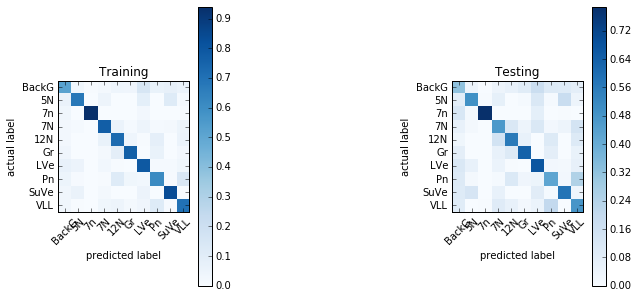

In [52]:
cm_train = confusion_matrix(training_y, predict_labels_train);
cm_train = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(10, 5));
plt.subplot(131)
plt.imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Training');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45);
plt.yticks(tick_marks, labels);

cm_test = confusion_matrix(testing_y, predict_labels_test);
cm_test = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]
plt.subplot(133)
plt.imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Testing');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45);
plt.yticks(tick_marks, labels);

In [126]:
class HistEstimator (BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5):
        self.threshold = threshold;
        self.prototypes = [];
        self.classes_ = np.arange(10);
        
#     def set_params(self, threshold=0.5):
#         self.threshold = threshold;
        
    def fit(self, X, y, sample_weight):
        if X.shape[0] == 0: 
            raise ValueError('0 sample(s) while a minimum of 1 is required');
        if X.shape[1] == 0:
            raise ValueError('0 feature(s) (shape=({}, 0)) while a minimum of 1 is required.'.format(X.shape[0]));
        if X.shape[0] != y.shape[0]:
            raise ValueError('X and y should have same first d');
        if X[np.isnan(X)].shape[0] > 0 or X[np.isinf(X)].shape[0] > 0:
            raise ValueError('X should not contain Nan or Inf.');
            
        # Get prototype of each class histogram by averaging them
        sample_weight = sample_weight * X.shape[0];
        weights = np.transpose(np.tile(sample_weight, (X.shape[1], 1)));
        X = np.multiply(X, weights);
        for i in range(0, 10):
            xi = [x[0] for x in zip(X, y) if x[1] == i];
            n = len(xi);
            xi = np.asarray(xi, dtype=float);
            xi = np.sum(xi, axis=0);
            xi = xi / n;
            self.prototypes.append(xi);
        return self;

    def predict(self, X):
        # Predict label 
        specialist = np.asarray(self.prototypes);
        # Calculate histogram intersection score (larger means more similar).
        scores = [];
        for i in range(0, specialist.shape[0]):
            score = 0.5 * np.sum(X + specialist[i] - np.abs(X - specialist[i]), axis=1);
            scores.append(score);
        max_scores = np.max(np.asarray(scores), axis=0);
        max_index = np.argmax(np.asarray(scores), axis=0);
        # Classify as Bg if scores less than threshold
        max_index[max_scores < self.threshold] = 0;
        return max_index

In [87]:
#check_estimator(HistEstimator);

Base training takes 1.13342213631 sec.
Predict time 2.17374992371 sec.
Training accuracy: 0.506602943026
Testing accuracy: 0.503521126761


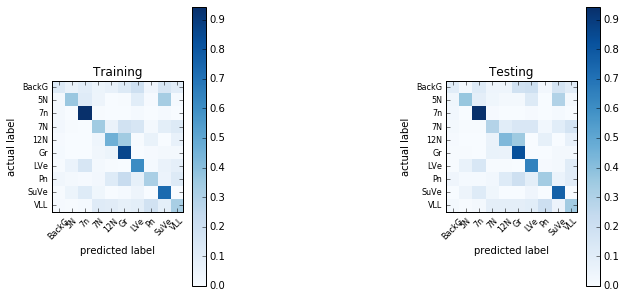

In [123]:
# Doing base classifier test
baseClassifier = HistEstimator(0.2);
initial_weights = np.ones(n_training) / n_training;
t = time();
baseClassifier.fit(training_X, training_y, initial_weights);
print "Base training takes {} sec.".format(time() - t);

base_predict_train = baseClassifier.predict(training_X);
t = time();
base_predict_test = baseClassifier.predict(testing_X);
print "Predict time {} sec.".format(time() - t);

base_n_correct_train = 0;
for i in range(n_training):
    if base_predict_train[i] == training_y[i]:
        base_n_correct_train += 1;
print "Training accuracy: {}".format(1.0*base_n_correct_train / n_training);

base_n_correct_test = 0;
for i in range(n_testing):
    if base_predict_test[i] == testing_y[i]:
        base_n_correct_test += 1;
print "Testing accuracy: {}".format(1.0*base_n_correct_test / n_testing);

cm_train_base = confusion_matrix(training_y, base_predict_train);
cm_train_base = cm_train_base.astype('float') / cm_train_base.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(10, 5));
plt.subplot(131)
plt.imshow(cm_train_base, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Training');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45, fontsize=8);
plt.yticks(tick_marks, labels, fontsize=8);

cm_test_base = confusion_matrix(testing_y, base_predict_test);
cm_test_base = cm_test_base.astype('float') / cm_test_base.sum(axis=1)[:, np.newaxis]
plt.subplot(133)
plt.imshow(cm_test_base, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Testing');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45, fontsize=8);
plt.yticks(tick_marks, labels, fontsize=8);

In [127]:
# Apply base classifier to ada boost
bst_base = AdaBoostClassifier(
    HistEstimator(0.2),
    n_estimators=200,
    learning_rate=1.6,
    algorithm="SAMME");

In [128]:
t = time();
bst_base.fit(training_X, training_y);
print "AdaBoosting Training time: {}".format(time() - t);

AdaBoosting Training time: 1985.19661188


In [129]:
# Training accuracy
predict_bst_train = bst_base.predict(training_X);
n_correct_train_bst = 0;
for i in range(n_training):
    if predict_bst_train[i] == training_y[i]:
        n_correct_train_bst += 1;
print "Training accuracy: {}".format(1.0*n_correct_train_bst / n_training);

# Testing accuracy
predict_bst_test = bst_base.predict(testing_X);
n_correct_test_bst = 0;
for i in range(n_testing):
    if predict_bst_test[i] == testing_y[i]:
        n_correct_test_bst += 1;
print "Testing accuracy: {}".format(1.0*n_correct_test_bst / n_testing);

Training accuracy: 0.452395925041
Testing accuracy: 0.447183098592


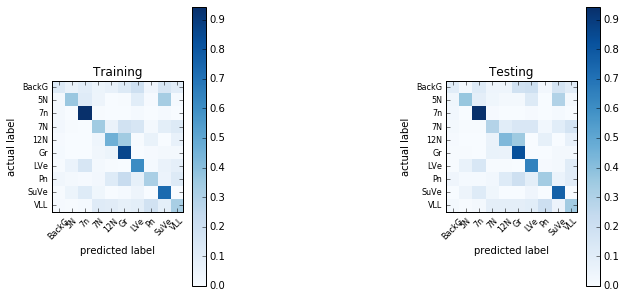

In [130]:
cm_train_bst = confusion_matrix(training_y, base_predict_train);
cm_train_bst = cm_train_bst.astype('float') / cm_train_bst.sum(axis=1)[:, np.newaxis]
fig = plt.figure(figsize=(10, 5));
plt.subplot(131)
plt.imshow(cm_train_bst, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Training');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45, fontsize=8);
plt.yticks(tick_marks, labels, fontsize=8);

cm_test_bst = confusion_matrix(testing_y, base_predict_test);
cm_test_bst = cm_test_bst.astype('float') / cm_test_bst.sum(axis=1)[:, np.newaxis]
plt.subplot(133)
plt.imshow(cm_test_bst, interpolation='nearest', cmap=plt.cm.Blues);
plt.ylabel('actual label');
plt.xlabel('predicted label')
plt.title('Testing');
plt.colorbar();
tick_marks = np.arange(len(labels));
plt.xticks(tick_marks, labels, rotation=45, fontsize=8);
plt.yticks(tick_marks, labels, fontsize=8);